In [6]:
%load_ext autoreload
%autoreload 2
! pip install -q git+https://github.com/tornikeo/cosine-similarity@dev

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from cudams.utils import argbatch, mkdir, get_ref_spectra_from_df, get_spectra_batches
from cudams.similarity.kernels import compile_cuda_cosine_greedy_kernel
import math
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from numba import cuda
from itertools import product
from time import perf_counter
from multiprocessing.pool import ThreadPool
from multiprocessing import shared_memory
import numpy as np
import json
import matplotlib.pyplot as plt

assert cuda.is_available()

In [40]:
## How many pairs per batch. Has to be a power of 2.
# Hardware specific - An RTX2070 works best at around 1024 * 2
# But Colab T4 GPU might work best at 1024 * 4
BATCH_SIZE = 1024

# MAX NUMBER OF PEAKS 
MAX_PEAKS = 1024

# MATCH_LIMIT specifies max how many mz-mz pairs we could consider for each RQ pair, before we sort and filter. 
# E.g. a value of 256 usually causes around ~0.003% of RQ pairs to "overflow".
# The overflown RQ scores will be strictly less than or equal to perfectly accurate score.
# The mean absolute difference at 256, for all overflown pairs is on the order of ~1e-3
# Small values of MATCH_LIMIT (e.g. 128, 64,) cause a dramatic speedup in the processing speed.
MATCH_LIMIT = 1024


In [46]:
from cudams.data import download

download()

ModuleNotFoundError: No module named 'cudams.data'

In [4]:
from joblib import Parallel, delayed
from matchms.filtering import default_filters, normalize_intensities, \
    reduce_to_number_of_peaks
from matchms.importing import load_from_mgf

def parse_spectrum(spectrum):
    spectrum = default_filters(spectrum)
    spectrum = reduce_to_number_of_peaks(spectrum, n_max=MAX_PEAKS)
    spectrum = normalize_intensities(spectrum)
    return spectrum
    
spectrums = Parallel(-2)(delayed(parse_spectrum)(spec) 
                         for spec in tqdm(load_from_mgf('data/GNPS-LIBRARY.mgf')))
spectrums = [spe for spe in spectrums if spe is not None]

In [30]:
references = spectrums[:512]
queries = spectrums[:512]

In [31]:
from matchms.similarity import CosineGreedy
from matchms import calculate_scores
from cudams.similarity import CudaCosineGreedy
from joblib import Parallel, delayed

scores = calculate_scores(references=references,
                          queries=queries,
                          similarity_function=CosineGreedy(),
                          is_symmetric=True).to_array()
print(f"Size of matrix of computed similarities: {scores.shape}")

Size of matrix of computed similarities: (512, 512)


In [37]:
match_limits = np.linspace(512, 2048, 8)
scores_cu = []
for match_limit in tqdm(match_limits):
    match_limit = int(match_limit)
    score = calculate_scores(
        references=references,
        queries=queries,
        similarity_function=CudaCosineGreedy(match_limit=match_limit, batch_size=BATCH_SIZE)
    ).to_array()
    scores_cu.append(score)

100%|██████████| 8/8 [00:29<00:00,  3.75s/it]


In [41]:
x = []
y = []

score = scores['CosineGreedy_score']
matches = scores['CosineGreedy_matches']

R, Q = BATCH_SIZE, BATCH_SIZE
for match_limit, score_cu_ in zip(match_limits, scores_cu):
    
    score_cu = score_cu_['CudaCosineGreedy_score']
    matches_cu = score_cu_['CudaCosineGreedy_matches']
    overflow_cu = score_cu_['CudaCosineGreedy_overflow']
    y_row = []
    print('@ MATCH_LIMIT', match_limit)

    score_eq = np.isclose(score, score_cu)
    score_corr = score_eq.mean()
    print("mean(score_gpu == score_cpu):", score_corr)
    y_row.append(score_corr)
    
    matches_eq = np.isclose(matches, matches_cu)
    matches_corr = matches_eq.mean()
    print("mean(num_match_gpu == num_match_cpu):", matches_corr)
    y_row.append(matches_corr)

    overflow_mean = overflow_cu.mean()
    y_row.append(1 - overflow_mean)
    print("1 - mean(overflow)", 1 - overflow_mean)
    
    y.append(y_row)
    x.append(match_limit)

@ MATCH_LIMIT 512.0
mean(score_gpu == score_cpu): 0.9997825622558594
mean(num_match_gpu == num_match_cpu): 0.9997825622558594
1 - mean(overflow) 0.9997825622558594
@ MATCH_LIMIT 731.4285714285714
mean(score_gpu == score_cpu): 0.9999732971191406
mean(num_match_gpu == num_match_cpu): 0.9999656677246094
1 - mean(overflow) 0.9999656677246094
@ MATCH_LIMIT 950.8571428571429
mean(score_gpu == score_cpu): 0.9999961853027344
mean(num_match_gpu == num_match_cpu): 0.9999961853027344
1 - mean(overflow) 0.9999961853027344
@ MATCH_LIMIT 1170.2857142857142
mean(score_gpu == score_cpu): 1.0
mean(num_match_gpu == num_match_cpu): 1.0
1 - mean(overflow) 1.0
@ MATCH_LIMIT 1389.7142857142858
mean(score_gpu == score_cpu): 1.0
mean(num_match_gpu == num_match_cpu): 1.0
1 - mean(overflow) 1.0
@ MATCH_LIMIT 1609.142857142857
mean(score_gpu == score_cpu): 1.0
mean(num_match_gpu == num_match_cpu): 1.0
1 - mean(overflow) 1.0
@ MATCH_LIMIT 1828.5714285714284
mean(score_gpu == score_cpu): 1.0
mean(num_match_gpu == 

Text(0.5, 0, 'MATCH_LIMIT')

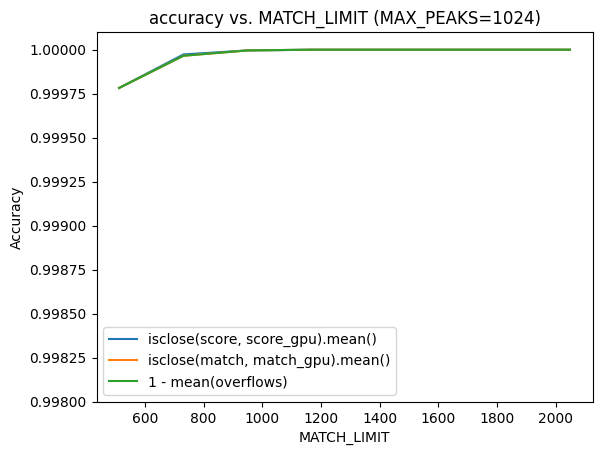

In [44]:
plt.plot(x,np.array(y))
plt.ylim([.998,1.0001])

plt.title(f"accuracy vs. MATCH_LIMIT (MAX_PEAKS={MAX_PEAKS})")
plt.legend(['isclose(score, score_gpu).mean()',
            'isclose(match, match_gpu).mean()',
            "1 - mean(overflows)"])
plt.ylabel("Accuracy")
plt.xlabel("MATCH_LIMIT")

Text(0.5, 0, 'MATCH_LIMIT')

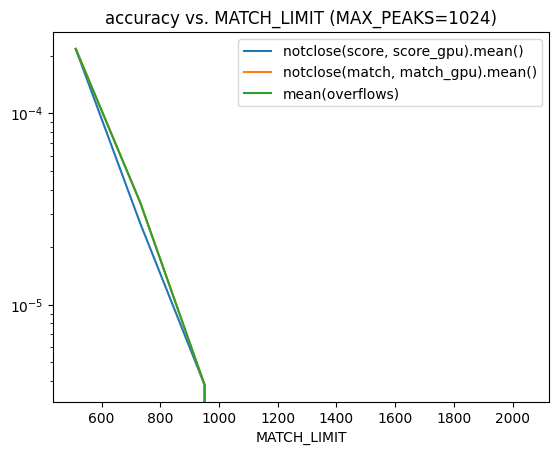

In [45]:
plt.semilogy(x, 1 - np.array(y))
plt.title(f"accuracy vs. MATCH_LIMIT (MAX_PEAKS={MAX_PEAKS})")
plt.legend(['notclose(score, score_gpu).mean()',
            'notclose(match, match_gpu).mean()',
            "mean(overflows)"])
plt.xlabel("MATCH_LIMIT")